<a href="https://colab.research.google.com/github/KIRANKUMAR886/sennitment_analysis/blob/master/keras_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, GlobalMaxPooling1D, Flatten, Conv1D, Dropout, Activation
from keras.preprocessing.text import Tokenizer

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import re
import string

from sklearn.model_selection import train_test_split

# For reproducibility
from tensorflow import set_random_seed
from numpy.random import seed
seed(1)
set_random_seed(2)

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

In [0]:
data=pd.read_csv('/content/train_F3WbcTw.csv')
data=data.dropna()

In [0]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    # GPU
    BATCH_SIZE = 128 # Number of examples used in each iteration
    EPOCHS = 10 # Number of passes through entire dataset
    VOCAB_SIZE = 30000 # Size of vocabulary dictionary
    MAX_LEN = 500 # Max length of review (in words)
    EMBEDDING_DIM = 40 # Dimension of word embedding vector

# Hyperparams for CPU training
else:
    # CPU
    BATCH_SIZE = 32
    EPOCHS = 50
    VOCAB_SIZE = 200000
    MAX_LEN = 150 #90
    EMBEDDING_DIM = 80 #40

In [0]:
LABELS=list(data['sentiment'].unique())

In [77]:
LABELS

[2, 1, 0]

In [0]:
train,val=train_test_split(data,test_size=0.1)

In [79]:
# How a row/sample looks like
print("\n--- First Sample ---")
print('Label:', train['sentiment'][0])
print('Text:', train['text'][0])


--- First Sample ---
Label: 2
Text: Autoimmune diseases tend to come in clusters. As for Gilenya – if you feel good, don’t think about it, it won’t change anything but waste your time and energy. I’m taking Tysabri and feel amazing, no symptoms (other than dodgy color vision, but I’ve had it since always, so, don’t know) and I don’t know if it will last a month, a year, a decade, ive just decided to enjoy the ride, no point in worrying.


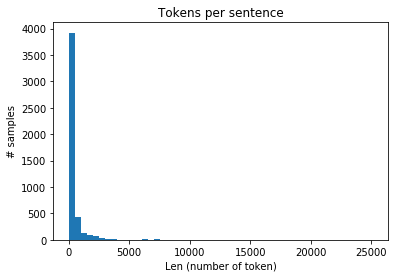

In [80]:
# Custom Tokenizer
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

# Plot sentence by lenght
plt.hist([len(tokenize(s)) for s in train['text'].values], bins=50)
plt.title('Tokens per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

DATA PREPROCESSING

Before feeding the data into the model, we have to preprocess the text.

    We will use the Keras Tokenizer to convert each word to a corresponding integer ID. Representing words as integers saves a lot of memory!
    In order to feed the text into our CNN, all texts should be the same length. We ensure this using the sequence.pad_sequences() method and MAX_LEN variable. All texts longer than MAX_LEN are truncated and shorter texts are padded to get them to the same length.

The Tokens per sentence plot (see above) is useful for setting the MAX_LEN training hyperparameter.

In [81]:
sentiment_tokenizer = Tokenizer(num_words=VOCAB_SIZE)
sentiment_tokenizer.fit_on_texts(train['text'].values)

x_train_seq = sentiment_tokenizer.texts_to_sequences(train['text'].values)
x_val_seq = sentiment_tokenizer.texts_to_sequences(val['text'].values)

x_train = sequence.pad_sequences(x_train_seq, maxlen=MAX_LEN, padding="post", value=0)
x_val = sequence.pad_sequences(x_val_seq, maxlen=MAX_LEN, padding="post", value=0)

y_train, y_val = train['sentiment'].values, val['sentiment'].values

print('First sample before preprocessing: \n', train['text'].values[0], '\n')
print('First sample after preprocessing: \n', x_train[0])

First sample before preprocessing: 
 "Remicade just isn't working for me or not yet. When I did my 1 and 2 infusions I could tell a difference. I had my 3 on and have to wait 8 weeks. After 3 weeks I had a flare up and I am in week 6 and I still feel awful. Maybe I need them more frequently or a higher dose. I am feeling so darn frustrated. I was hoping for a miracle drug to make me feel better and so far it's not. I read how it helps everyone but I want that for me too! Can't wait to see my dr so we can get ask up and the pain" 

First sample after preprocessing: 
 [ 144   78 1265  350    8   44   12   23  447   62    7  152   17   40
    2   48  723    7  121  290    5  956    7   34   17   59   14    2
   16    4  834  154  106   53   59  106    7   34    5  702   69    2
    7   84    6  140   87    2    7  134  233 2639  514    7  160  178
   41 1793   12    5  555  120    7   84  405   38 6634 4011    7   18
 1017    8    5 2973   64    4  181   44  233  171    2   38  460  270
 

In [0]:
#Network



# Model Parameters - You can play with these

NUM_FILTERS = 250
KERNEL_SIZE = 3
HIDDEN_DIMS = 250




In [83]:
# CNN Model
print('Build model...')
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into EMBEDDING_DIM dimensions
model.add(Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LEN))
model.add(Dropout(0.2))

# we add a Convolution1D, which will learn NUM_FILTERS filters
model.add(Conv1D(NUM_FILTERS,
                 KERNEL_SIZE,
                 padding='valid',
                 activation='relu',
                 strides=1))

# we use max pooling:
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(HIDDEN_DIMS))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 150, 80)           16000000  
_________________________________________________________________
dropout_7 (Dropout)          (None, 150, 80)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 148, 250)          60250     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 250)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 250)               62750     
_________________________________________________________________
dropout_8 (Dropout)          (None, 250)               0         
_________________________________________________________________
activation_7 (Activation)    (None, 250)               0     


**Train & Evaluate**

If you left the default hyperpameters in the Notebook untouched, your training should take approximately:

    On CPU machine: 2 minutes for 2 epochs.
    On GPU machine: 1 minute for 2 epochs.

You should get an accuracy of > 84%. Note: The model will start overfitting after 2 to 3 epochs.


In [0]:
# fit a model
model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_split=0.1,
          verbose=2)

# Evaluate the model
score, acc = model.evaluate(x_val, y_val, batch_size=BATCH_SIZE)
print('\nAccuracy: ', acc*100)

pred = model.predict_classes(x_val)

Train on 4275 samples, validate on 476 samples
Epoch 1/50
 - 46s - loss: -8.1627e+00 - acc: 0.1609 - val_loss: -9.1769e+00 - val_acc: 0.1639
Epoch 2/50
 - 44s - loss: -9.7109e+00 - acc: 0.1612 - val_loss: -9.1769e+00 - val_acc: 0.1639
Epoch 3/50
 - 44s - loss: -9.7109e+00 - acc: 0.1612 - val_loss: -9.1769e+00 - val_acc: 0.1639
Epoch 4/50
 - 44s - loss: -9.7109e+00 - acc: 0.1612 - val_loss: -9.1769e+00 - val_acc: 0.1639
Epoch 5/50
